In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import sparse

In [4]:
dtr = pd.read_csv('data/train.csv')
dts = pd.read_csv('data/test.csv')

In [5]:
dtr.head()

,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount,price
0,2016-07-01 00:00:43.000000,Рязанская область,Mitsubishi,Outlander,Внедорожник,Белый,Левый,2014,Бензин,2.0,45000,Полный,Вариатор,150.0,NaN,1200000.0
1,2016-07-01 00:01:11.000000,Москва,ВАЗ (LADA),2109,Хетчбэк,Серебряный,Левый,2002,Бензин,1.5,180000,Передний,Механика,78.0,NaN,58000.0
2,2016-07-01 00:01:12.000000,Санкт-Петербург,УАЗ,Patriot,Внедорожник,Зелёный,Левый,2015,Бензин,2.7,1,Полный,Механика,128.0,NaN,499000.0
3,2016-07-01 00:01:14.000000,Санкт-Петербург,Ford,Mondeo,Седан,Серый,Левый,2005,Бензин,2.0,160000,Передний,Автомат,146.0,2,249990.0
4,2016-07-01 00:01:42.000000,Тверская область,ГАЗ,ГАЗель,Фургон,Белый,Левый,2005,Бензин,2.4,100000,Задний,Механика,125.0,NaN,250000.0


In [9]:
dts.head()

,id,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount
0,0,2016-12-01 00:00:33.000000,Саратовская область,Infiniti,G35,Седан,Бежевый,Левый,2008,Бензин,3.5,145000,Полный,Автомат,316.0,3
1,1,2016-12-01 00:00:36.000000,Москва,Skoda,Yeti,Внедорожник,Серебряный,Левый,2014,Бензин,1.2,47630,Передний,Механика,102.0,1
2,2,2016-12-01 00:00:52.000000,Тульская область,Peugeot,408,Седан,Белый,Левый,2012,Бензин,1.6,88000,Передний,Механика,113.0,1
3,3,2016-12-01 00:00:52.000000,Тверская область,Daewoo,Nexia,Седан,Серебряный,Левый,2012,Бензин,1.6,55766,Передний,Механика,109.0,1
4,4,2016-12-01 00:00:56.000000,Москва,Citroen,C4,Седан,Серый,Левый,2014,Бензин,1.6,30591,Передний,Автомат,150.0,1


Посмотрим на пропуски в данных.

In [6]:
dtr_missing = dtr.isnull().sum(axis=0).reset_index()
dtr_missing.columns = ['name', 'count']
dtr_missing = dtr_missing.loc[dtr_missing['count'] > 0]

In [10]:
dts_missing = dts.isnull().sum(axis=0).reset_index()
dts_missing.columns = ['name', 'count']
dts_missing = dts_missing.loc[dts_missing['count'] > 0]

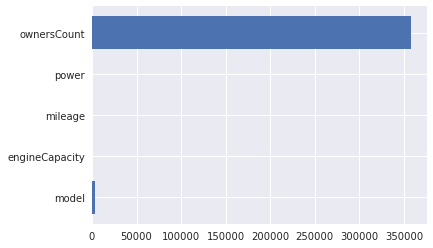

In [7]:
fig, ax = plt.subplots()
ind = np.arange(dtr_missing.shape[0])
_ = ax.barh(ind, dtr_missing['count'])
ax.set_yticks(ind)
ax.set_yticklabels(dtr_missing['name'].values, rotation='horizontal')

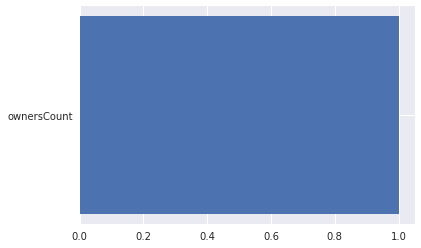

In [11]:
fig, ax = plt.subplots()
ind = np.arange(dts_missing.shape[0])
_ = ax.barh(ind, dts_missing['count'])
ax.set_yticks(ind)
ax.set_yticklabels(dts_missing['name'].values, rotation='horizontal')

Основную часть пропущенных данных составляют число владельцев. Заполним пропущенные данные в числе владельцев на произвольный атрибут, остальные пропуски удалим.

In [12]:
dtr['ownersCount'].unique()

array([nan, '2', '3', '4+', '1'], dtype=object)

In [13]:
dtr['ownersCount'].fillna(value='0', inplace=True)
dts['ownersCount'].fillna(value='0', inplace=True)

In [14]:
dtr.dropna(inplace=True)
dts.dropna(inplace=True)

Преобразуем текстовые данные пробега вида '# - #' в число.

In [15]:
import re
pattern = re.compile(r'\b\d+\b')

dtr['mileage'] = dtr['mileage'].apply(lambda x: np.mean(list(map(float, re.findall(pattern, x.replace(' ', ''))))) if type(x) is str else x)

In [16]:
dts['mileage'] = dts['mileage'].apply(lambda x: np.mean(list(map(float, re.findall(pattern, x.replace(' ', ''))))) if type(x) is str else x)

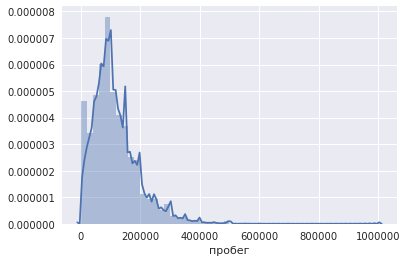

In [9]:
dtr['mileage'].describe()
ax = sns.distplot(dtr['mileage'])
ax.set_xlabel('пробег')

Поступим с объемом двигателя похожим образом.

In [12]:
dtr['engineCapacity'].unique()

array(['2.0', '1.5', '2.7', '2.4', '1.7', '1.6', '1.0', '1.4', '2.5',
       '1.1', '1.8', '4.7', '2.2', '3.0', '1.9', '4.4', '4.2', '3.8',
       '2.8', '1.2', '2.3', '2.9', '0.7', '5.5', '3.6', '4.6', '6.0+',
       '1.3', '3.5', '0.6', '4.0', '3.7', '4.5', '3.2', '4.8', '5.6',
       '4.3', '0.8', '2.6', '2.1', '3.4', '6.0', '5.0', '3.3', '5.3',
       '3.9', '5.2', '5.7', '5.9', '0.9', '4.1', '5.8', '5.4', '5.1',
       '3.1', '4.9'], dtype=object)

In [18]:
dtr.loc[dtr['engineCapacity'] == '6.0+', 'engineCapacity'] = 6.0
dts.loc[dts['engineCapacity'] == '6.0+', 'engineCapacity'] = 6.0

In [19]:
dtr['engineCapacity'] = dtr['engineCapacity'].astype(float)
dts['engineCapacity'] = dts['engineCapacity'].astype(float)

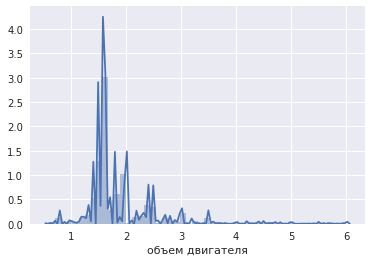

In [15]:
ax = sns.distplot(dtr['engineCapacity'])
ax.set_xlabel('объем двигателя')

In [20]:
dtr.loc[dtr['yearOfCar'] == 'до 1960', 'yearOfCar'] = 1960
dts.loc[dts['yearOfCar'] == 'до 1960', 'yearOfCar'] = 1960

In [21]:
dtr['yearOfCar'] = dtr['yearOfCar'].astype(int)
dts['yearOfCar'] = dts['yearOfCar'].astype(int)

count    2.183486e+06
mean     2.005796e+03
std      6.957180e+00
min      1.960000e+03
25%      2.002000e+03
50%      2.007000e+03
75%      2.011000e+03
max      2.017000e+03
Name: yearOfCar, dtype: float64

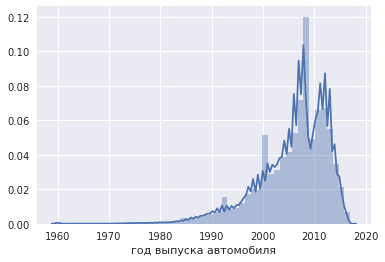

In [18]:
ax = sns.distplot(dtr['yearOfCar'])
ax.set_xlabel('год выпуска автомобиля')
dtr['yearOfCar'].describe()

In [13]:
dtr.apply(pd.Series.nunique)

startTime           1894662
region                   84
brand                   138
model                  1772
carcassType              12
color                    16
typeOfSteering            2
yearOfCar                58
engineType                5
engineCapacity           55
mileage               59197
driveType                 3
transmissionType          4
power                   873
ownersCount               5
price                 15709
dtype: int64

In [3]:
# list of categorical variables 
col_cat = ['region', 'brand', 'model', 'carcassType', 'color', 'typeOfSteering', 'engineType', 'driveType', 'transmissionType', 'ownersCount'] 
# list of categorical variables #
col_cat_ = ['region', 'brand', 'model'] 
# list of numerical variables 
col_num = ['yearOfCar', 'engineCapacity', 'mileage', 'power'] 
# col_num = ['yearOfCar', 'engineCapacity', 'mileage', 'power', 'power_to_cap', 'brand_model_median', 'xrate1', 'xrate2', 'xrate3']
# target variable 
col_tar = ['price']

Посмотрим на зависимости между целевой переменной.

In [22]:
mask = dtr[(dtr['price'] < dtr['price'].quantile(0.9999)) & (dtr['price'] > dtr['price'].quantile(0.0001))].index 

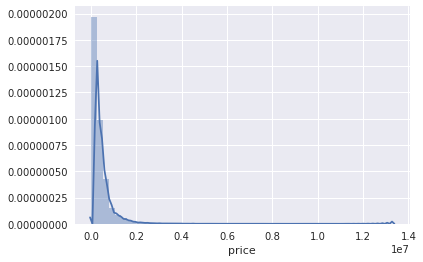

In [23]:
sns.distplot(dtr['price'][mask])

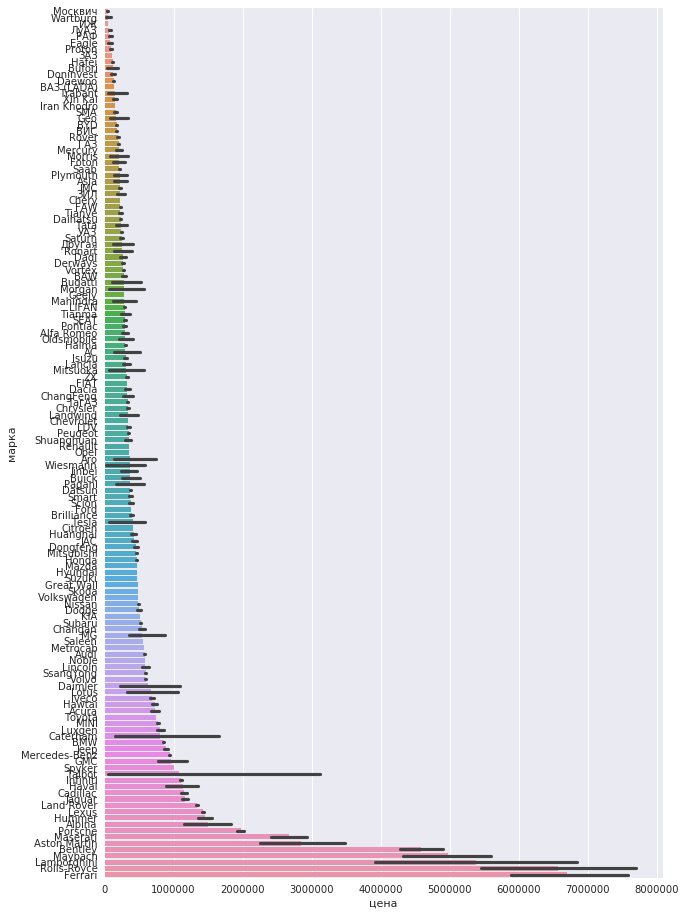

In [25]:
col = 'brand' 
plt.figure(figsize=(10, 16)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index) 
ax.set_ylabel('марка')
ax.set_xlabel('цена')

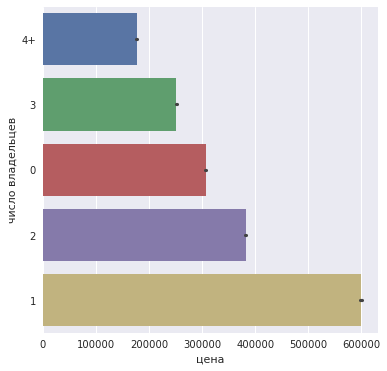

In [28]:
col = 'ownersCount' 
plt.figure(figsize=(6, 6)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index) 
ax.set_ylabel('число владельцев')
ax.set_xlabel('цена')

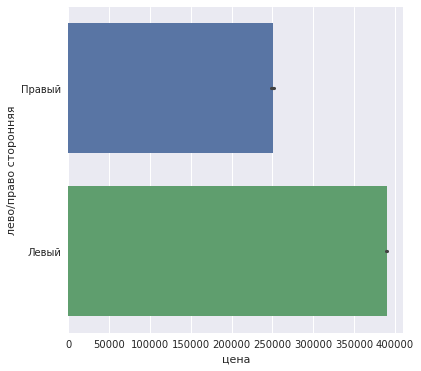

In [27]:
col = 'typeOfSteering' 
plt.figure(figsize=(6, 6)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index)
ax.set_ylabel('лево/право сторонняя')
ax.set_xlabel('цена')

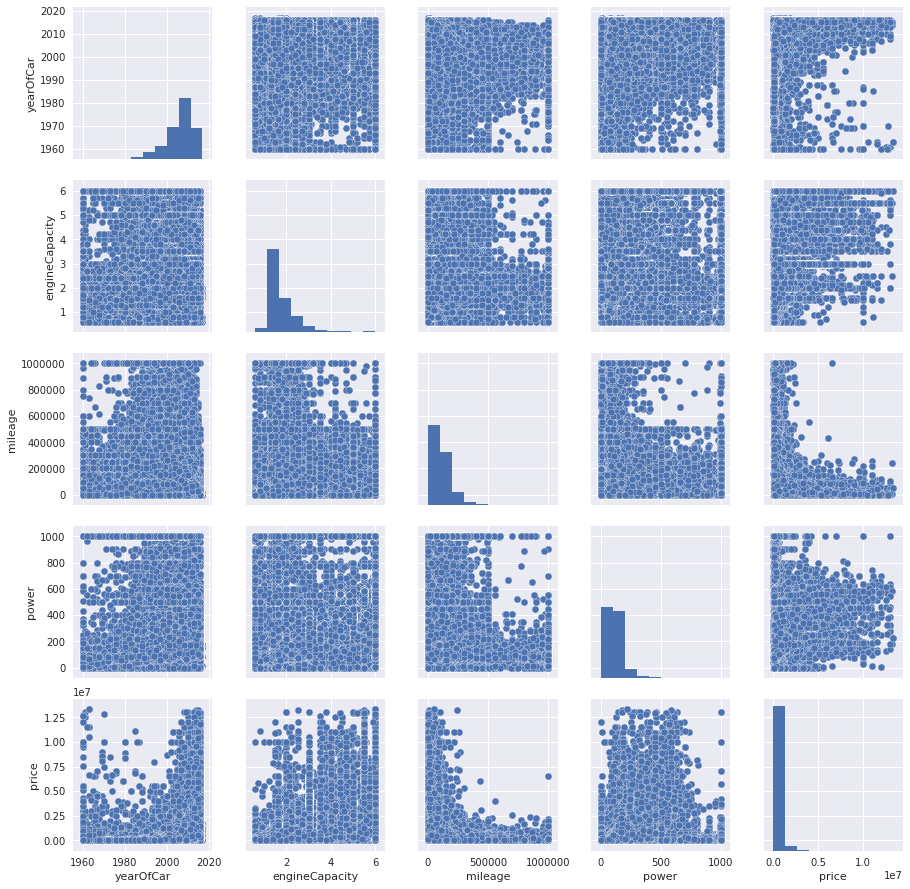

In [29]:
sns.pairplot(data=dtr.loc[mask][col_num + col_tar])

Посмотрим на выбросы в целевой переменной.

count    2.183486e+06
mean     2.005298e+06
std      7.861775e+08
min      0.000000e+00
25%      1.100000e+05
50%      2.490000e+05
75%      4.750000e+05
max      1.000000e+12
Name: price, dtype: float64

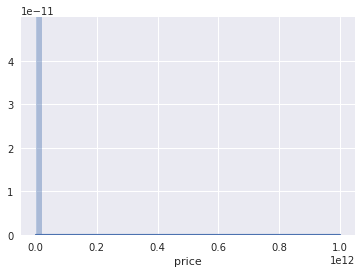

In [15]:
sns.distplot(dtr['price'])
dtr['price'].describe()

Средняя цена всех категорий автомобилей составляет ~250 тысяч едениц. Понятно, что она отличается в разы по маркам, пробегу, году выпуска. 
Для поиска выбросов, воспользуемся какой-нибудь простой моделью, устройчивой к ним.

In [25]:
for col in col_cat:
    enc = LabelEncoder()
    enc.fit(list(dtr[col].values) + list(dts[col].values))
    dtr[col] = enc.transform(dtr[col])
    dts[col] = enc.transform(dts[col])
    # dtr[col] = enc.fit_transform(dtr[col])
    dtr[col] = dtr[col].astype('category')
    dts[col] = dts[col].astype('category')

In [26]:
enc = OneHotEncoder()
scaler = StandardScaler()
X = np.array(dtr[col_num])
X = scaler.fit_transform(X)
X = sparse.hstack([X, enc.fit_transform(dtr[col_cat])])

In [27]:
y = np.array(dtr[col_tar])
y_ = np.log1p(y)

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

In [19]:
param_grid = {
    'eta0': [1, 5, 10],
    'alpha': [0.00001, 0.0001],
    'l1_ratio': [0.0],
    'n_iter': [300]
}

In [ ]:
grid = GridSearchCV(SGDRegressor(loss='huber', penalty='l1', verbose=10), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=64) 
grid.fit(X, y)

In [167]:
grid.best_params_

{'alpha': 1e-05, 'eta0': 10, 'l1_ratio': 0.0, 'n_iter': 300}

In [29]:
reg = SGDRegressor(loss='huber', penalty='l1', verbose=10, alpha=1e-05, eta0=10, l1_ratio=0.0, n_iter=300)

In [ ]:
reg.fit(X, y)

In [31]:
y_pred = reg.predict(X)

Медианное абсолютное отклонение, как пороговая функция.

In [32]:
mad_median = np.median(y[:, 0] - y_pred)
mad_diff = np.abs(y[:, 0] - y_pred - mad_median)
mad_diff_median = np.median(mad_diff)
mad_zscore = 0.6745*mad_diff/mad_diff_median

In [33]:
dtr['outlier'] = (mad_zscore > 1000)

In [23]:
dtr[dtr['outlier']].sort_values(by='price', ascending=False)

,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount,price,outlier
1138044,2016-09-21 16:06:57.000000,30,1,903,11,0,0,2010,0,1.5,35000.0,0,2,50.0,4,1.000000e+12,True
2063800,2016-11-22 09:42:19.000000,6,126,70,8,11,0,1996,0,1.5,130.0,1,2,79.0,3,4.000000e+11,True
431559,2016-08-04 21:42:00.000000,17,26,1069,11,3,0,2006,0,0.8,30000.0,1,2,51.0,0,1.212121e+11,True
2073152,2016-11-22 19:12:01.000000,34,126,183,0,4,0,2001,0,1.7,120000.0,2,2,59.0,4,9.000010e+10,True
862201,2016-09-03 08:44:23.000000,30,128,1753,10,1,0,2011,0,2.3,150000.0,0,2,107.0,3,8.995553e+10,True
1093647,2016-09-18 17:47:20.000000,30,126,69,11,4,0,1998,0,1.5,150000.0,1,2,69.0,3,8.989822e+10,True
76839,2016-07-10 13:15:51.000000,30,117,474,8,12,1,1995,0,2.2,150000.0,1,0,145.0,0,8.989751e+10,True
1003110,2016-09-12 16:07:45.000000,35,126,75,11,4,0,2006,0,1.5,110000.0,1,2,75.0,3,8.981701e+10,True
1791226,2016-11-02 19:01:05.000000,19,126,851,8,15,0,2013,0,1.6,80000.0,1,2,98.0,2,8.965499e+10,True
1748261,2016-10-30 22:23:45.000000,19,126,69,11,15,0,2003,0,5.5,100000.0,1,2,650.0,2,8.964033e+10,True


Для наглядности покажем, как отличаются средние цены по брендам для данных, помеченных как "выброс" против остальных.

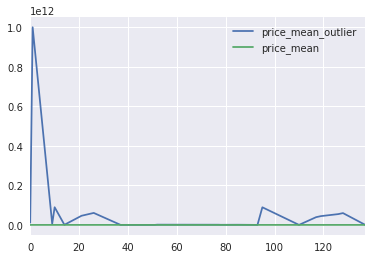

In [116]:
dtr_outliers_comp = dtr.loc[dtr['outlier']][['brand', 'price']].groupby(by='brand').mean().reset_index().dropna()
dtr_outliers_comp = pd.merge(dtr_outliers_comp, dtr.loc[~dtr['outlier']][['brand', 'price']], how='inner', on=['brand']).groupby(by='brand').mean().reset_index().dropna()
dtr_outliers_comp.columns = ['brand', 'price_mean_outlier', 'price_mean']
dtr_outliers_comp.plot()

Данные с нулевыми ценами, так же пометим, как выбросы.

In [34]:
dtr.loc[dtr['price'] == 0, 'outlier'] = True

Небольшое преобразование данных + дообогатим их курсами валют на текущую дату, 15 и 30 дней назад.

In [35]:
dtr['power_to_cap'] = 0
dts['power_to_cap'] = 0
dtr.loc[dtr['engineCapacity'] > 0, 'power_to_cap'] = dtr.loc[dtr['engineCapacity'] > 0, 'power']/dtr.loc[dtr['engineCapacity'] > 0, 'engineCapacity'] 
dts.loc[dts['engineCapacity'] > 0, 'power_to_cap'] = dts.loc[dts['engineCapacity'] > 0, 'power']/dts.loc[dts['engineCapacity'] > 0, 'engineCapacity'] 
col_num.append('power_to_cap')

In [42]:
dtr['brand_model_median'] = 0
dts['brand_model_median'] = 0
dtr_brand_model_median = dtr[['brand', 'model', 'price']].groupby(by=['brand', 'model']).agg(np.median).reset_index()
dtr['brand_model_median'] = pd.merge(dtr[['brand', 'model']], dtr_brand_model_median, how='inner', on=['brand', 'model'])['price']
dts['brand_model_median'] = pd.merge(dts[['brand', 'model']], dtr_brand_model_median, how='inner', on=['brand', 'model'])['price']
col_num.append('brand_model_median')

In [47]:
d_usdrub = pd.read_csv('usdrub.csv', delimiter=',')
d_usdrub = d_usdrub.ix[:, [2, 7]]
d_usdrub.columns = ['date', 'value']
d_usdrub['date'] = d_usdrub['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
d_usdrub = d_usdrub.set_index('date', drop=True)

d_usdrub = pd.concat([d_usdrub, d_usdrub.shift(15, 'D'), d_usdrub.shift(30, 'D')], axis=1).reset_index()
d_usdrub.dropna(inplace=True)
d_usdrub.columns = ['startTime_', 'xrate1', 'xrate2', 'xrate3']

d_usdrub = pd.concat([d_usdrub, pd.DataFrame([[pd.to_datetime('2017-01-22'), 59.6800, 59.6140, 60.9356]], columns=d_usdrub.columns)], axis=0, ignore_index=True)

In [60]:
dtr['startTime_'] = dtr['startTime'].astype('datetime64[D]')
dts['startTime_'] = dts['startTime'].astype('datetime64[D]')

In [61]:
dtr[['xrate1', 'xrate2', 'xrate3']] = pd.merge(dtr[['startTime_']], d_usdrub, how='left', on='startTime_')[['xrate1', 'xrate2', 'xrate3']]
dts[['xrate1', 'xrate2', 'xrate3']] = pd.merge(dts[['startTime_']], d_usdrub, how='left', on='startTime_')[['xrate1', 'xrate2', 'xrate3']]
col_num.append(['xrate1', 'xrate2', 'xrate3'])

In [5]:
dtr = dtr[~dtr['outlier']]

In [6]:
print(dtr.shape, dts.shape)

(2144997, 24) (416023, 23)


In [7]:
d_cat = pd.concat([dtr[col_cat], dts[col_cat]], axis=0)
d_num = pd.concat([dtr[col_num], dts[col_num]], axis=0)

In [8]:
print(d_cat.shape, d_num.shape)

(2561020, 10) (2561020, 9)


MAPE до этого не известная мне метрика.
Для моделей с функцией оптимизации второго порядка не работает совсем, т.к. Гессиан функции обращается в ноль.
Тут https://arxiv.org/pdf/1605.02541.pdf указывают на то, что ее можно посчитать в моделях регрессии, как MAE + задать веса для каждого тренировочного примера.
Я тренировал нейронную сеть с прямой связью + использовал различные трансформации целевой переменной.

In [9]:
enc = OneHotEncoder(sparse=False) 
scaler = StandardScaler()

X = np.array(d_num)
X[:, -3] = X[:, -3] - X[:, -2]
X[:, -2] = X[:, -2] - X[:, -1]
X = scaler.fit_transform(X)
X = np.hstack([X, enc.fit_transform(d_cat).astype(np.int8)])

In [10]:
y = np.array(dtr[col_tar])

In [11]:
y_ = np.log1p(y)

In [26]:
"""
# box-cox transformation
from scipy.stats import boxcox
from scipy.special import inv_boxcox
y_ = boxcox(y)
# standard scale
y = dtr[col_tar]
y = scaler.fit_transform(y)
# standard scale without mean
y_n = dtr[col_tar]
scaler_n = StandardScaler(with_mean=False)
y_n = scaler_n.fit_transform(y_n)
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
y_mx = dtr[col_tar]
scaler_mx = MinMaxScaler()
y_mx = scaler_mx.fit_transform(y_mx)
"""

In [12]:
X, X_p = X[:dtr.shape[0], :], X[dtr.shape[0]:, :]

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y_)

In [ ]:
# froscipy.specialpecial.inv_boxcox

In [14]:
from keras.layers import Dense, Dropout, Activation, Merge
from keras.models import Sequential 
from keras.regularizers import l1 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adadelta, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

from sklearn.preprocessing import StandardScaler 
from scipy import sparse

Using TensorFlow backend.


In [15]:
checkpoint_callback = ModelCheckpoint(filepath='keras_')
early_stopping_callback = EarlyStopping(min_delta = 0.05, patience=2)

In [16]:
optimizer_ = Adam(lr=0.0005)
# optimizer_ = Adadelta(lr=0.5)
# optimizer_ = SGD(lr=0.1)
# optimizer_ = 'rmsprop'

dropout = 0.4
init = 'glorot_normal'
activation = 'relu'

N = X_tr.shape[1]
N_d = 3

model_d = Sequential()
model_d.add(Dense(int(N/N_d), input_dim=N, init=init, W_regularizer=l1(0.0001)))
model_d.add(Activation(activation))
model_d.add(BatchNormalization())
model_d.add(Dropout(dropout))

model_d.add(Dense(int(N/N_d), init=init))
model_d.add(Activation(activation))
model_d.add(BatchNormalization())
model_d.add(Dropout(dropout))

model_d.add(Dense(1, init=init))
model_d.add(Activation('linear'))

model_w = Sequential()
model_w.add(Dense(1, input_dim=N, init=init))
model_w.add(Activation('linear'))

model = Sequential()
model.add(Merge([model_w, model_d], mode='concat', concat_axis=1))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_percentage_error', optimizer=optimizer_, metrics=['mae', 'mse'])

model.summary()
hist = model.fit([X_tr, X_tr], y_tr, validation_data = ([X_te, X_te], y_te), epochs=100, batch_size=64, callbacks=[checkpoint_callback, early_stopping_callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 1,859,806.0
Trainable params: 1,857,086.0
Non-trainable params: 2,720.0
_________________________________________________________________
Train on 1608747 samples, validate on 536250 samples
Epoch 1/100
1608747/1608747 [==============================] - 319s - loss: 5.1362 - mean_absolute_error: 0.4786 - mean_squared_error: 2.8061 - val_loss: 2.9615 - val_mean_absolute_error: 0.2180 - val_mean_squared_error: 0.3207
Epoch 2/100
1608747/1608747 [==============================] - 336s - loss: 2.9569 - mean_absolute_error: 0.2188 - mean_squared_error: 0.3197 - val_loss: 2.9156 - val_mean_absolute_error: 0.2156 - val_mean_squared_error: 0.3189
Epoch 3/1

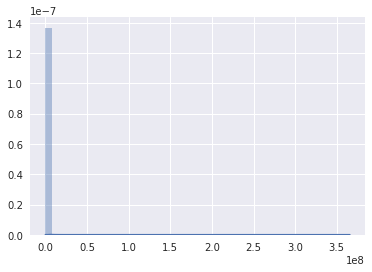

In [17]:
y_pred = model.predict([X_p, X_p])
y_pred = np.expm1(y_pred)
sns.distplot(y_pred)

In [18]:
dts['price'] = y_pred

In [19]:
dts[['id', 'price']].to_csv('prediction.csv')

Про оценку диапозона цен. Если за функцию потерь взять RMSE, то точкой, минимизирующих данную функцию, будет среднее распределения. Оценив среднее и точность регрессии, предположив, скажем, что для каждой марки цена распределена нормально, можно оценить диапозон цен.